# Exposure Time Calculator

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
import pandas as pd
from astroquery.vizier import Vizier
from scipy.optimize import curve_fit

In [2]:
def estimate_threshold(img_data):
    """
    Estimate threshold for DAOStarFinder using sigma-clipped statistics
    """
    mean, median, std = sigma_clipped_stats(img_data, sigma=3.0)  
    threshold= 5.0* std
    return threshold, mean, median, std


In [3]:
def star_finder(img_data, thre, med):
    """
    Detect sources using DAOStarFinder.
    """
    daofind = DAOStarFinder(fwhm=5, threshold=thre) 
    sources = daofind(img_data - med) # subtract the background
    for col in sources.colnames:
        sources[col].info.format = '%.8g' # for consistent table output
    return sources

In [4]:
# Measure the peak flux of the stars using aperture photometry
def measure_peak_flux(img_data, sources, aperture_radius,exp_time):
    """
    Measure the peak flux of the stars using aperture photometry.
    """
    peak_flux = []
    for source in sources:
        position = (source['xcentroid'], source['ycentroid'])
        aperture = CircularAperture(position, r=aperture_radius)
        # Calculate the extent of the circular aperture
        y, x = np.indices(img_data.shape)
        aperture_indices = (x - position[0])**2 + (y - position[1])**2 <= aperture_radius**2
        # Extract pixel values within the aperture using NumPy indexing
        aperture_data = img_data[aperture_indices]
        peak_flux.append(np.max(aperture_data)/exp_time) #Peak pixel per second
    return peak_flux 

In [5]:
def catalog_data_fetch(ra, dec, max_pixel, filter_name):
    """Fetch magnitude data from the NOMAD catalog based on the filter."""
    catalog_name = "I/297"  # NOMAD catalog
    filter_columns = {
        'B': 'Bmag',
        'V': 'Vmag',
        'R': 'Rmag'
    }
    
    if filter_name not in filter_columns:
        raise ValueError(f"Unsupported filter '{filter_name}'. Supported filters are B, V, R.")
    mag_column = filter_columns[filter_name]
    mags, cat_ras, cat_decs = [], [], []
    
    for i in range(len(ra)):
        ra_val = ra[i].deg
        dec_val = dec[i].deg
        result = Vizier.query_region(SkyCoord(ra_val, dec_val, unit='deg', frame='icrs'),
                                     radius=5*u.arcsec, catalog=catalog_name, column_filters={mag_column: "<20"})
        if result is not None and len(result) > 0:
            mag = result[0][mag_column][0]
            cat_ra = result[0]['RAJ2000'][0]
            cat_dec = result[0]['DEJ2000'][0]
            mags.append(mag)
            cat_ras.append(cat_ra)
            cat_decs.append(cat_dec)
        else:
            mags.append(None)
            cat_ras.append(None)
            cat_decs.append(None)

    star_data = pd.DataFrame({'RA': ra, 'Dec': dec, 'Pixel_Count': max_pixel, 'Mag': mags, 'Cat_Ra': cat_ras, 'Cat_Dec': cat_decs})
    return star_data

In [6]:
def expo_fit(x,a,b):
    """
    Exponential fit function.
    """
    y= a * np.exp(b * x)
    return y

def perform_exponential_fit(x, y):
    """
    Perform exponential fitting and return fitted parameters.
    """
    popt, _ = curve_fit(expo_fit, x, y)
    model_y = expo_fit(x, *popt)    
    return popt

def extrapolate_magnitude(new_magnitudes, popt):
    """
    Extrapolate peak counts based on the exponential fit.
    """
    return expo_fit(new_magnitudes, *popt)

In [13]:
def plot_extrapolation(new_magnitudes, extrapolated_peak, filter_name):
    """Plot the extrapolated curve."""
    plt.figure()
    plt.plot(new_magnitudes, extrapolated_peak, 'g-', label="Extrapolated Curve")
    plt.xlabel(f'{filter_name} Magnitude', fontsize="15")
    plt.ylabel('Peak Count', fontsize="15")
    plt.title(f'{filter_name} Filter Relation', fontsize="15")
    plt.tick_params(axis='both', labelsize=15)
    plt.tight_layout()
    plt.savefig(f'{filter_name.lower()}_relation.png', format='png', dpi=1200)
    plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


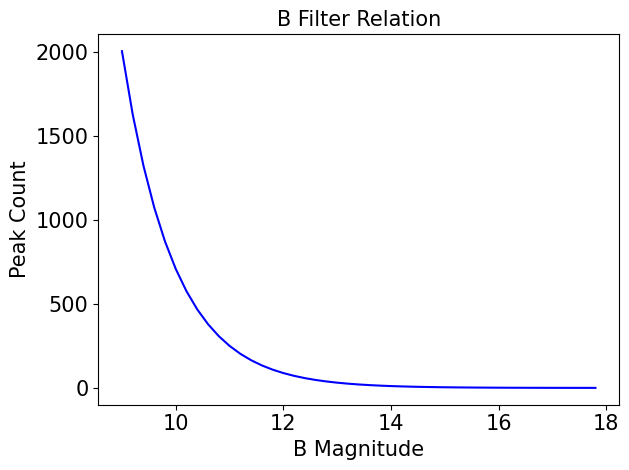

In [14]:
def main(file, filter_name):
    hdul = fits.open(file)
    img_data = hdul[0].data
    wcs = WCS(hdul[0].header)
    
    # Estimate threshold and find stars
    threshold, mean, median, std = estimate_threshold(img_data)
    sources = star_finder(img_data, threshold, median)
        
    # Measure peak flux
    aperture_radius = 4.0
    exposure_time = hdul[0].header.get('EXPOSURE')
    max_pixel = measure_peak_flux(img_data, sources, aperture_radius, exposure_time)
    
    # Convert pixel positions to RA and Dec
    sky_coords = wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])
    ra = sky_coords.ra
    dec = sky_coords.dec
    
    # Fetch catalog data
    match_data = catalog_data_fetch(ra, dec, max_pixel, filter_name)
    pd.set_option('display.max_rows', None)
    
    # Filter and sort data for fitting
    star_data = match_data.dropna(subset=['Pixel_Count', 'Mag']).sort_values(by='Mag', ascending=True)
    x = star_data['Mag']
    y = star_data['Pixel_Count']
    
    # Perform exponential fit
    popt = perform_exponential_fit(x, y)
    model_y = expo_fit(x, *popt)
        
    # Extrapolate to new magnitudes and plot
    new_magnitudes = np.arange(9, 18, 0.2)
    extrapolated_peak = extrapolate_magnitude(new_magnitudes, popt)
    plot_extrapolation(new_magnitudes, extrapolated_peak, filter_name)

if __name__ == "__main__":
    file = 'NGC6992_1-V-E030-S001-R0001-C0001_r.fts'
    filter_name = 'V'  # Change this to 'B', 'V', or 'R' as needed
    main(file, filter_name)